A Variational Auto-Encoder (VAE) is comprised of three important parts:

1. An encoder $q_\phi(z|x)$ which estimates the mean $\mu$ and variance $\sigma^2$ of the latent variable $z$
2. A reparametrization block which applies the reparameterization technique to sample from the latent space (sample = $\mu + \sigma*\epsilon$ where $\epsilon$ is sampled from a standard Gaussian $\mathcal{N}(0, I)$)
3. A decoder $p_\theta(x|z)$ which gets a sample from the latent space and recovers the data


**Important implementation tip**: It is customary for the VAEs to estimate $\log(\sigma^2)$ rather than $\sigma^2$

The loss function of the VAEs is usually made from two parts:
1. A reconstruction loss (e.g., the $L_1$ distance or Binary Croos-Entropy between the original image and the reconstructed one)
2. $KL(q_\phi(z|x)\| \mathcal{N}(0, I))$, which tries to make the distribution of the latent variables $z$ as similar to the standard Gaussian as possible.

The class-conditional VAE is similar to a regular VAE, with the difference that the classes are embedded and combined with the latent variable and then passed to the deocder.

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive/')
dir = "/content/drive/MyDrive/CMPUT328/VAEAndDiffusion/"
# ----------------------------------------
sys.path.append(dir)
import os
os.chdir("/content/drive/MyDrive/VAEAndDiffusion/")
# importing the necessary packages
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

from A5_vae_submission import VAE
kwargs = {'root':'FashionMNIST',
          'train':True,
          'transform':transforms.ToTensor(),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

def train(vae: VAE,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          reg_factor: float=1.,
          device=torch.device('cuda'),
          display_interval: int=5):

  itrs = tqdm(range(epochs))
  itrs.set_description(f'Train Recons Loss: ? - Train Prior Loss: ? (Total: ?)- '
                       f'Val Recons Loss: ? - Val Prior Loss: ? (Total: ?)')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    avg_prior_loss = 0.
    avg_recons_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      y = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      recons_loss, prior_loss = vae.get_loss(x, y)

      loss = recons_loss + reg_factor * prior_loss

      avg_prior_loss += prior_loss.item()
      avg_recons_loss += recons_loss.item()
      avg_train_loss += loss.item()

      loss.backward()
      optimizer.step()

    avg_recons_loss /= len(train_loader)
    avg_prior_loss /= len(train_loader)
    avg_train_loss /= len(train_loader)

    # validation and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      avg_val_prior_loss = 0.
      avg_val_recons_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        y = sample[1].type(torch.long).to(device)

        recons_loss, prior_loss = vae.get_loss(x, y)

        loss = recons_loss + reg_factor * prior_loss

        avg_val_prior_loss += prior_loss.item()
        avg_val_recons_loss += recons_loss.item()
        avg_val_loss += loss.item()

      avg_val_prior_loss /= len(val_loader)
      avg_val_recons_loss /= len(val_loader)
      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Recons Loss: {avg_recons_loss:.3f} - Train Prior Loss: {avg_prior_loss:.3f} (Total: {avg_train_loss:.3f})- '
                         f'Val Recons Loss: {avg_val_recons_loss:.3f} - Val Prior Loss: {avg_val_prior_loss:.3f} (Total: {avg_val_loss:.3f})')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(vae.state_dict(), 'vae.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = vae.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Mounted at /content/drive/


In [ ]:
# setting the training hyperparameters
device = torch.device('cuda')
batch_size = 128 # specify your batch size
num_classes = 10
hidden_dim = 400
latent_dim = 20
class_emb_dim = 10
vae = VAE(hidden_dim=hidden_dim, latent_dim=latent_dim, class_emb_dim=class_emb_dim, num_classes=num_classes)
lr = 0.001
optimizer = optim.Adam(vae.parameters(), lr)
reg_factor = 1 # specify the regularization factor for the prior matching loss
epochs = 10 # feel free to change the epochs as needed
num_classes = 10
display_interval = 5

# defining the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# moving the model to gpu
vae = vae.to(device)

# training the model
train(vae=vae,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      reg_factor=reg_factor,
      device=device,
      display_interval=display_interval)

generated_sample = vae.generate_sample(1, torch.tensor([0]).cuda(), device)

plt.imshow(generated_sample[0].squeeze(0).cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
# a classifier trained on FashionMNIST
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

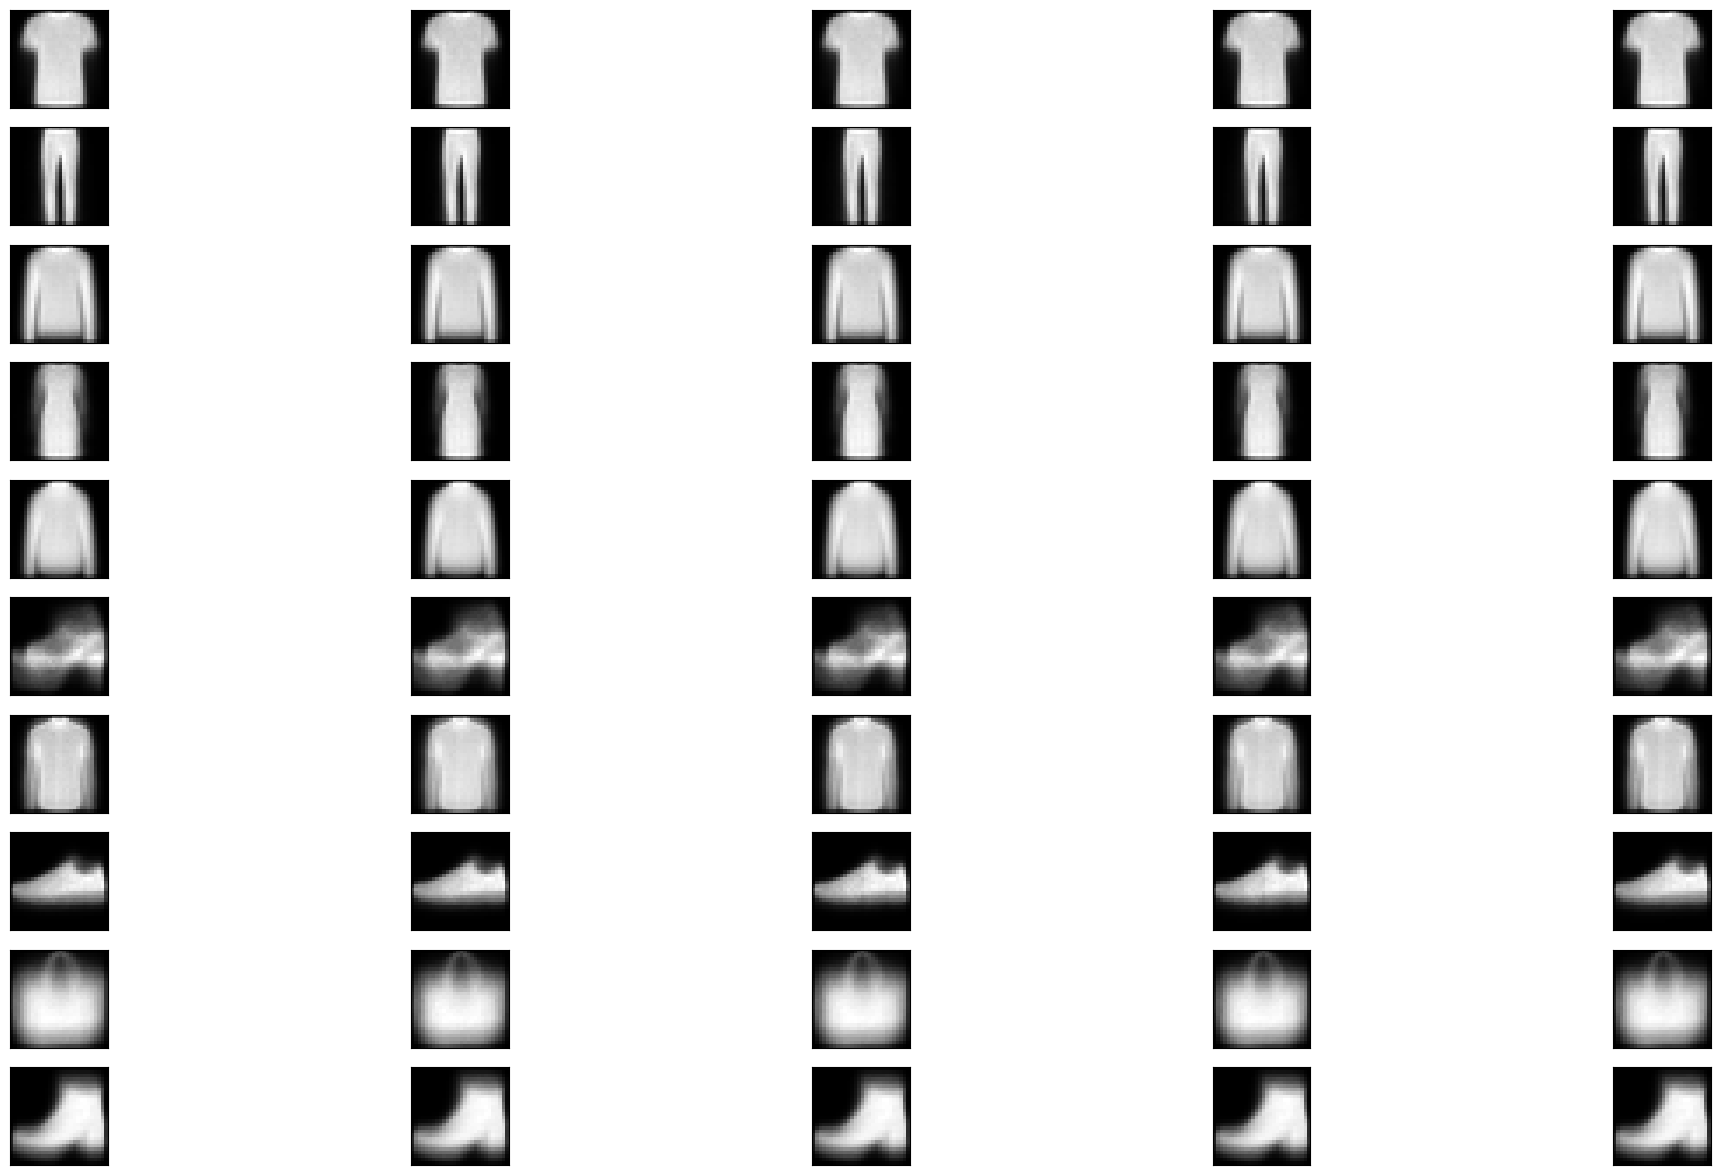

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 6, 6, 6, 6,
        6, 7, 9, 5, 9, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
82.00


In [ ]:
# here we use the classifier to see if how well it can classify the generated images
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).cuda()

# load your vae
vae.load_state_dict(torch.load('vae.pt'))
vae = vae.to(device)

# generate samples from the VAE
generated_samples = vae.generate_sample(50, desired_labels, torch.device('cuda'))

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')